In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm


device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)


cuda:0


In [2]:
#with open('files_remove_indices/small_data_remove_list_indexes.npy', 'wb') as f:
#    np.save(f, images_containing_nine)

with open('files_remove_indices/small_data_remove_list_indexes.npy', 'rb') as f:
    remove_list = np.load(f)

In [3]:


from torch.utils.data import Dataset, DataLoader
import glob
import rasterio
class SwedishDataset(Dataset):
    def __init__(self,  transform  = None, remove_list = None):
        self.imgs_path = "SwedenData/100tiles/"
        file_list_dem1 = sorted(glob.glob(self.imgs_path + 'dem/'+ "*/*"))
        file_list_sat1 = sorted(glob.glob(self.imgs_path + 'sat/'+ "*/*"))

        self.data = []
        for img_path_dem,img_path_sat in zip(file_list_dem1,file_list_sat1):
          self.data.append([img_path_dem,img_path_sat])

        self.transform = transform
        #self.dems1_list = file_list_dem1 
        #self.sat1_list = file_list_sat1
        if remove_list is not None:
            self.data = np.array(self.data)
            mask = np.ones(len(self.data), dtype=bool)
            mask[remove_list] = False
            self.data = self.data[mask]

        
    def __len__(self):
        return len(self.data)


    def convert_to_classes(self, temp_tensor):
          mask_tensor_1 = (temp_tensor == 111)|(temp_tensor == 112)|(temp_tensor == 113)|(temp_tensor == 114)|(temp_tensor== 115)|(temp_tensor == 116)|(temp_tensor == 117) 
          mask_tensor_2 = (temp_tensor == 118)
          mask_tensor_3 = (temp_tensor == 121)|(temp_tensor == 122)|(temp_tensor == 123)|(temp_tensor== 124)|(temp_tensor == 125)|(temp_tensor == 126)|(temp_tensor == 127)
          mask_tensor_4 = (temp_tensor == 128)
          mask_tensor_5 = (temp_tensor == 2)
          mask_tensor_6 = (temp_tensor == 3)
          mask_tensor_7 = (temp_tensor == 41)|(temp_tensor== 42)
          mask_tensor_8 = (temp_tensor == 51)|(temp_tensor == 52)|(temp_tensor == 53)
          mask_tensor_9 = (temp_tensor == 61)|(temp_tensor == 62)
          mask_tensor_outside = (temp_tensor==0)
          mask_tensors = [mask_tensor_1,mask_tensor_2,mask_tensor_3,mask_tensor_4,
                          mask_tensor_5,mask_tensor_6, mask_tensor_7,mask_tensor_8,
                          mask_tensor_9, mask_tensor_outside]
          temp_image = temp_tensor
          for i in range(10):
            temp_image = torch.where(mask_tensors[i], torch.tensor(i), temp_image)
          return temp_image
    
          
    def __getitem__(self, idx):
        img_path_dem, img_path_sat = self.data[idx]
        img_raster_dem = rasterio.open(img_path_dem).read()#[:,:96,:96]
        img_raster_sat = rasterio.open(img_path_sat).read()#[:,:170,:350]
        img_raster_sat = self.convert_to_classes(torch.from_numpy(img_raster_sat))
        
        if img_raster_dem[0].shape!=(100,100):
            if img_raster_dem[0][0,0]==0:
                img_raster_dem = img_raster_dem[:,1:,:]
            else:
                img_raster_dem = img_raster_dem[:,:-1,:]
        
        if self.transform:
            img_raster_dem = self.transform(torch.tensor(img_raster_dem))
        
        test = img_raster_sat
        outside_class = 9
        if torch.equal(test[0][0,:], torch.ones(len(test[0][0,:]))*outside_class):
            test = test[:,1:,:]
        if torch.equal(test[0][-1,:], torch.ones(len(test[0][-1,:]))*outside_class):
            test = test[:,:-1,:]
        if torch.equal(test[0][:,0], torch.ones(len(test[0][:,0]))*outside_class):
            test = test[:,:,1:]
        if torch.equal(test[0][:,-1], torch.ones(len(test[0][:,-1]))*outside_class):
            test = test[:,:,:-1]
        img_raster_sat = test
        img_raster_sat = mask_resize(img_raster_sat)
        
        return [img_raster_dem ,img_raster_sat[0].type(torch.LongTensor)]
    
    
    
    
    
def normalize_input_for_dem(test_iter):
    #test_iter = torch.from_numpy(test_iter)
    input_images = test_iter.float()
    #maxv = 822
    #minv = -37
    batch_size = input_images.shape[0]
    cmin = torch.amin(input_images,(1,2)).reshape((batch_size,1,1))
    cmax = torch.amax(input_images,(1,2)).reshape((batch_size,1,1))
    return (input_images-cmin)/(cmax-cmin)#(input_images-minv)/(maxv-minv) #(input_images-cmin)/(cmax-cmin)

class Normalize_range01:
    #bring to range 0 to 1

    def __init__(self, p=1):
        self.p = 1

    def __call__(self, x):
        result = normalize_input_for_dem(x)
        return result

    def __repr__(self):
        return "custom augmentation"

img_size = (96,96)
mask_resize = transforms.Resize(size = img_size, interpolation=Image.NEAREST)
#dem_resize = transforms.Resize(size = img_size)
data_transforms = transforms.Compose([#transforms.ToTensor(),
                                          transforms.Resize(size = img_size),
                                          Normalize_range01(),
                                          #transforms.ToPILImage(), 
                                          #transforms.RandomHorizontalFlip(),
                                          #transforms.RandomResizedCrop(size=100),
                                          #transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
                                          #transforms.RandomGrayscale(p=0.2),
                                          #transforms.GaussianBlur(kernel_size=9),
                                          #transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

from torch.utils.data import random_split
import math
dataset = SwedishDataset(transform = data_transforms, remove_list = remove_list)
#train_data, test_data = random_split(dataset, [math.ceil(len(dataset)*0.8), math.floor(len(dataset)*0.2)])
#train_size = math.ceil(len(dataset)*0.9)
#test_size = math.floor(len(dataset)*0.1)
#train_dataset = torch.utils.data.Subset(dataset, range(train_size))
#test_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))

#print(len(train_dataset))
#print(len(test_dataset))

#print(dataset[4][0].shape)
#dataset[4]


In [21]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1, test_size=.15, random_state=0)
for i, (train_index, test_index) in enumerate(rs.split(dataset)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[2172 1218 1924 ...  763  835 1653]
  Test:  index=[1874 2097  711 1325   53  965 1248  501  962 1154 1646 1052  320  883
 2246 2015  224  314   69 1382  132 1310 2201  811  789  713 1013 1794
 1197 1537 1836 1045 1355 2273  361 1166  148 2182 2031  712  385  672
  487  657  629  768 2192  820  817 1935 1213  512 1580  532  995  582
 1821   98 1150 2070   10 1618  156  728 1122 2215 1629  535 1754 1549
 2102  810  579  917  521 1492 1893 1971 1815 1101 1273  966  568 2026
  438 1097 1513 1687 1449   39 1635 1507  195 2077 1843 1319   70  459
  651  251 2210 2092 2272 2155  286 1327 1380  892 1018 1025 1239  692
 1335 1292   57 1074 1996  480  220 1511 1023  124  182 1525 1266 2032
  581  918  530  384  446 1853  245 1001 1136  405  162 1135  135 1518
 1302 1368  701  443  955 1183 2219 2184 1946 1087 1099 1797 2108  107
  596  402    1  553 1375   76  667  727  682 1693 1704 1856  457 2066
 1613 1128  981 1859  296  575  949 1301  399 2127 1825 1564   14  792
 21

In [4]:
#with open('files_remove_indices/train_set_indexes.npy', 'wb') as f:
#    np.save(f, train_index)

#with open('files_remove_indices/test_set_indexes.npy', 'wb') as f:
#    np.save(f, test_index)

with open('files_remove_indices/train_set_indexes.npy', 'rb') as f:
    train_set_indexes = np.load(f)

with open('files_remove_indices/test_set_indexes.npy', 'rb') as f:
    test_set_indexes = np.load(f)

In [5]:
train_dataset = torch.utils.data.Subset(dataset, train_set_indexes)
test_dataset = torch.utils.data.Subset(dataset, test_set_indexes)
print(len(train_dataset))
print(len(test_dataset))

print(dataset[4][0].shape)
dataset[4]

1943
344
torch.Size([1, 96, 96])


/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[tensor([[[-0.3333, -0.3333, -0.3611,  ..., -0.7778, -0.7778, -0.8056],
          [-0.3611, -0.3889, -0.3889,  ..., -0.7778, -0.8056, -0.8056],
          [-0.3611, -0.3889, -0.3889,  ..., -0.7778, -0.8056, -0.8056],
          ...,
          [ 0.5278,  0.5556,  0.5833,  ..., -0.8333, -0.8611, -0.8333],
          [ 0.6389,  0.6667,  0.7222,  ..., -0.8333, -0.8611, -0.8333],
          [ 0.7222,  0.7500,  0.8056,  ..., -0.8333, -0.8333, -0.8611]]]),
 tensor([[0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 6, 0,  ..., 8, 8, 8],
         ...,
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8]])]

# Model

In [6]:

class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=1, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out


# In[98]:


num_classes = 9
model = UNet(num_classes=num_classes)


# Wandb reporting

# Training


In [7]:
import numpy as np
import torch
import torch.nn as nn


class SegmentationMetrics(object):
    r"""Calculate common metrics in semantic segmentation to evalueate model preformance.
    Supported metrics: Pixel accuracy, Dice Coeff, precision score and recall score.
    
    Pixel accuracy measures how many pixels in a image are predicted correctly.
    Dice Coeff is a measure function to measure similarity over 2 sets, which is usually used to
    calculate the similarity of two samples. Dice equals to f1 score in semantic segmentation tasks.
    
    It should be noted that Dice Coeff and Intersection over Union are highly related, so you need 
    NOT calculate these metrics both, the other can be calcultaed directly when knowing one of them.
    Precision describes the purity of our positive detections relative to the ground truth. Of all
    the objects that we predicted in a given image, precision score describes how many of those objects
    actually had a matching ground truth annotation.
    Recall describes the completeness of our positive predictions relative to the ground truth. Of
    all the objected annotated in our ground truth, recall score describes how many true positive instances
    we have captured in semantic segmentation.
    Args:
        eps: float, a value added to the denominator for numerical stability.
            Default: 1e-5
        average: bool. Default: ``True``
            When set to ``True``, average Dice Coeff, precision and recall are
            returned. Otherwise Dice Coeff, precision and recall of each class
            will be returned as a numpy array.
        ignore_background: bool. Default: ``True``
            When set to ``True``, the class will not calculate related metrics on
            background pixels. When the segmentation of background pixels is not
            important, set this value to ``True``.
        activation: [None, 'none', 'softmax' (default), 'sigmoid', '0-1']
            This parameter determines what kind of activation function that will be
            applied on model output.
    Input:
        y_true: :math:`(N, H, W)`, torch tensor, where we use int value between (0, num_class - 1)
        to denote every class, where ``0`` denotes background class.
        y_pred: :math:`(N, C, H, W)`, torch tensor.
    Examples::
        >>> metric_calculator = SegmentationMetrics(average=True, ignore_background=True)
        >>> pixel_accuracy, dice, precision, recall = metric_calculator(y_true, y_pred)
    """
    def __init__(self, eps=1e-5, average=True, ignore_background=True, activation='0-1'):
        self.eps = eps
        self.average = average
        self.ignore = ignore_background
        self.activation = activation

    @staticmethod
    def _one_hot(gt, pred, class_num):
        # transform sparse mask into one-hot mask
        # shape: (B, H, W) -> (B, C, H, W)
        input_shape = tuple(gt.shape)  # (N, H, W, ...)
        new_shape = (input_shape[0], class_num) + input_shape[1:]
        one_hot = torch.zeros(new_shape).to(pred.device, dtype=torch.float)
        target = one_hot.scatter_(1, gt.unsqueeze(1).long().data, 1.0)
        return target

    @staticmethod
    def _get_class_data(gt_onehot, pred, class_num):
        # perform calculation on a batch
        # for precise result in a single image, plz set batch size to 1
        matrix = np.zeros((3, class_num))

        # calculate tp, fp, fn per class
        for i in range(class_num):
            # pred shape: (N, H, W)
            class_pred = pred[:, i, :, :]
            # gt shape: (N, H, W), binary array where 0 denotes negative and 1 denotes positive
            class_gt = gt_onehot[:, i, :, :]

            pred_flat = class_pred.contiguous().view(-1, )  # shape: (N * H * W, )
            gt_flat = class_gt.contiguous().view(-1, )  # shape: (N * H * W, )

            tp = torch.sum(gt_flat * pred_flat)
            fp = torch.sum(pred_flat) - tp
            fn = torch.sum(gt_flat) - tp

            matrix[:, i] = tp.item(), fp.item(), fn.item()

        return matrix

    def _calculate_multi_metrics(self, gt, pred, class_num):
        # calculate metrics in multi-class segmentation
        matrix = self._get_class_data(gt, pred, class_num)
        if self.ignore:
            matrix = matrix[:, 1:]

        # tp = np.sum(matrix[0, :])
        # fp = np.sum(matrix[1, :])
        # fn = np.sum(matrix[2, :])

        pixel_acc = (np.sum(matrix[0, :]) + self.eps) / (np.sum(matrix[0, :]) + np.sum(matrix[1, :]))
        dice = (2 * matrix[0] + self.eps) / (2 * matrix[0] + matrix[1] + matrix[2] + self.eps)
        precision = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + self.eps)
        recall = (matrix[0] + self.eps) / (matrix[0] + matrix[2] + self.eps)

        if self.average:
            dice = np.average(dice)
            precision = np.average(precision)
            recall = np.average(recall)

        return pixel_acc, dice, precision, recall

    def __call__(self, y_true, y_pred):
        class_num = y_pred.size(1)

        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "softmax":
            activation_fn = nn.Softmax(dim=1)
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            pred_argmax = torch.argmax(y_pred, dim=1)
            activated_pred = self._one_hot(pred_argmax, y_pred, class_num)
        else:
            raise NotImplementedError("Not a supported activation!")

        gt_onehot = self._one_hot(y_true, y_pred, class_num)
        pixel_acc, dice, precision, recall = self._calculate_multi_metrics(gt_onehot, activated_pred, class_num)
        return pixel_acc, dice, precision, recall


class BinaryMetrics():
    r"""Calculate common metrics in binary cases.
    In binary cases it should be noted that y_pred shape shall be like (N, 1, H, W), or an assertion 
    error will be raised.
    Also this calculator provides the function to calculate specificity, also known as true negative 
    rate, as specificity/TPR is meaningless in multiclass cases.
    """
    def __init__(self, eps=1e-5, activation='0-1'):
        self.eps = eps
        self.activation = activation

    def _calculate_overlap_metrics(self, gt, pred):
        output = pred.view(-1, )
        target = gt.view(-1, ).float()

        tp = torch.sum(output * target)  # TP
        fp = torch.sum(output * (1 - target))  # FP
        fn = torch.sum((1 - output) * target)  # FN
        tn = torch.sum((1 - output) * (1 - target))  # TN

        pixel_acc = (tp + tn + self.eps) / (tp + tn + fp + fn + self.eps)
        dice = (2 * tp + self.eps) / (2 * tp + fp + fn + self.eps)
        precision = (tp + self.eps) / (tp + fp + self.eps)
        recall = (tp + self.eps) / (tp + fn + self.eps)
        specificity = (tn + self.eps) / (tn + fp + self.eps)

        return pixel_acc, dice, precision, specificity, recall

    def __call__(self, y_true, y_pred):
        # y_true: (N, H, W)
        # y_pred: (N, 1, H, W)
        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            sigmoid_pred = nn.Sigmoid()(y_pred)
            activated_pred = (sigmoid_pred > 0.5).float().to(y_pred.device)
        else:
            raise NotImplementedError("Not a supported activation!")

        assert activated_pred.shape[1] == 1, 'Predictions must contain only one channel' \
                                             ' when performing binary segmentation'
        pixel_acc, dice, precision, specificity, recall = self._calculate_overlap_metrics(y_true.to(y_pred.device,
                                                                                                    dtype=torch.float),
                                                                                          activated_pred)
        return [pixel_acc, dice, precision, specificity, recall]
    
metric_calculator = SegmentationMetrics(average=True, ignore_background=True)

# Evaluation

In [8]:
#model_path = "SwedenData/checkpoints/U-Net_normranged_normalized_smalldata_1000epoch_lr0001_3.pth"
model_path = "SwedenData/checkpoints/U-Net_normranged_normalized_smalldata_1000epoch_lr0001_4.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))
model_.eval()

UNet(
  (contracting_11): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contr

In [9]:
batch_size = 32
data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
testdata_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [45]:
train_batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle = True)
print("Train dataset size: ", len(train_dataset))
#model_.eval()
Y_list = []
Y_pred_N_list = []
Y_pred_list = []
with torch.no_grad():
    for X,Y in train_data_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_N = model_(X)
        Y_pred = torch.argmax(Y_pred_N, dim=1)
        Y_list.append(Y)
        Y_pred_N_list.append(Y_pred_N)
        Y_pred_list.append(Y_pred)

pixel_accuracy, dice, precision, recall = metric_calculator(torch.vstack(Y_list), torch.vstack(Y_pred_N_list))

Train dataset size:  1943


/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [46]:
print("Pixel accuracy: {:.2f}".format(pixel_accuracy))
print("Dice: {:.2f}".format(dice))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
f_score = 2*precision*recall/(precision+recall)
print('F-score: {:.2f}'.format(f_score))

Pixel accuracy: 0.99
Dice: 0.96
Precision: 0.94
Recall: 0.99
F-score: 0.96


In [47]:
from sklearn.metrics import classification_report
y_preds_flat = torch.vstack(Y_pred_list).data.cpu().numpy().reshape(1,-1)[0]
y_trues_flat = torch.vstack(Y_list).data.cpu().numpy().reshape(1,-1)[0]
report = classification_report(y_preds_flat, y_trues_flat,labels=[0, 1, 2, 3,4,5,6,7,8], output_dict = False)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   8128023
           1       1.00      0.99      0.99   1308467
           2       0.99      0.98      0.99    711973
           3       0.98      0.92      0.95      4144
           4       0.99      0.99      0.99   4840372
           5       1.00      0.70      0.83     13430
           6       0.98      0.98      0.98   1987464
           7       0.96      0.98      0.97    188289
           8       0.98      0.99      0.99    724526

    accuracy                           0.99  17906688
   macro avg       0.99      0.95      0.97  17906688
weighted avg       0.99      0.99      0.99  17906688



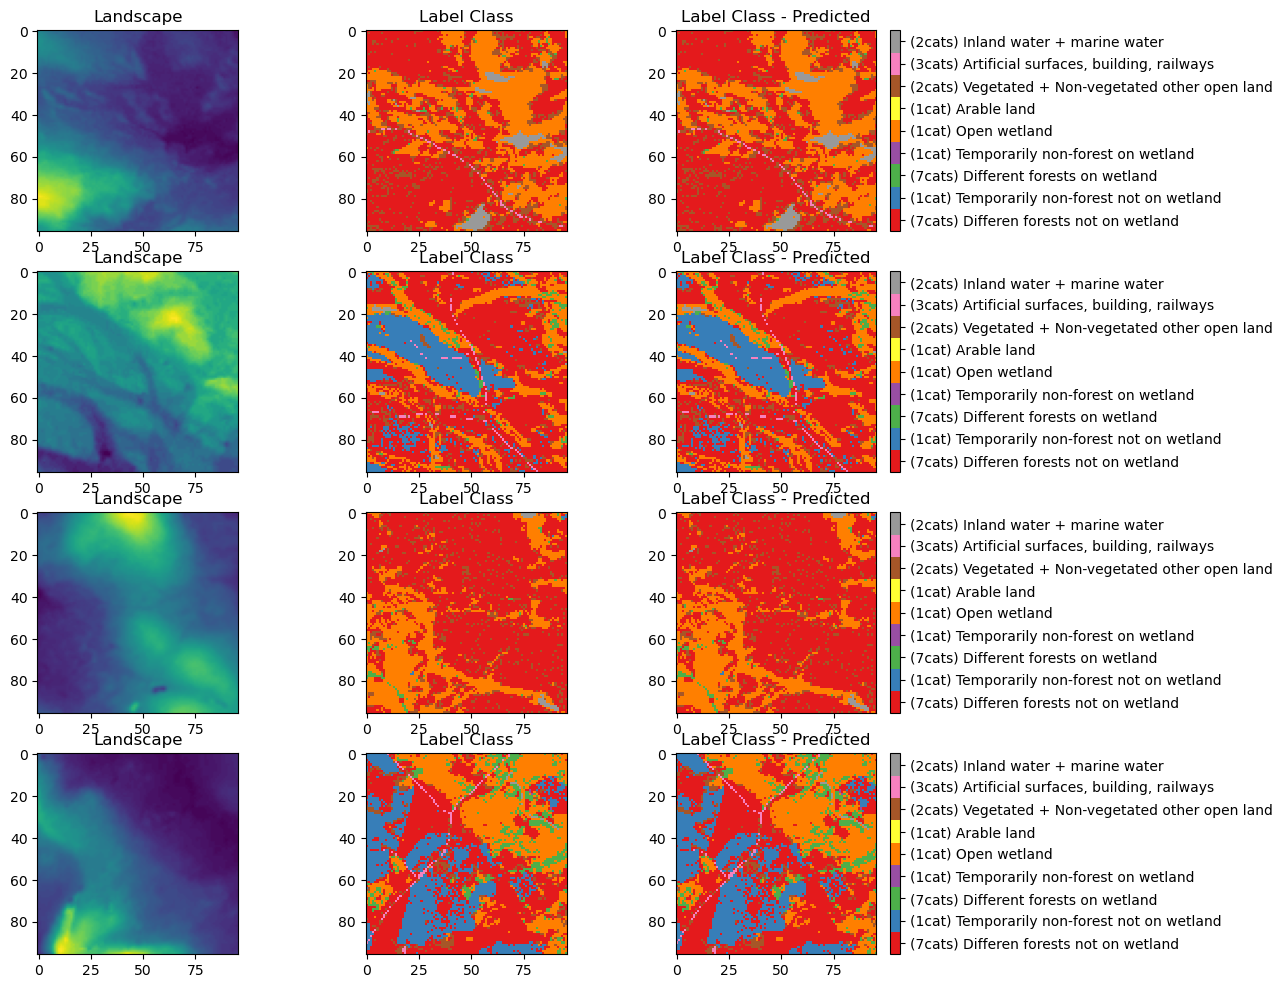

In [13]:
tick_labels = ['(7cats) Differen forests not on wetland',
               '(1cat) Temporarily non-forest not on wetland',
               '(7cats) Different forests on wetland',
               '(1cat) Temporarily non-forest on wetland',
               '(1cat) Open wetland',
               '(1cat) Arable land', 
               '(2cats) Vegetated + Non-vegetated other open land',
               '(3cats) Artificial surfaces, building, railways', 
               '(2cats) Inland water + marine water',
               #'Outside of mapping area'
               ]

num_samples = 4
fig, axes = plt.subplots(num_samples, 3, figsize=(3*4, num_samples*3))

for i in range(num_samples):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='Set1', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 1].set_title("Label Class")
    ax3 = axes[i, 2].imshow(label_class_predicted, cmap='Set1', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 2].set_title("Label Class - Predicted")
    cbar = plt.colorbar(ax3)
    ax3.set_clim(-0.5, 9 - 0.5)
    ticks = np.arange(9)
    cbar.set_ticks(ticks ,labels = tick_labels)
    #cmap='tab10' 'Set1'

In [40]:
#TEST DATASET
test_batch_size = 32

test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size,shuffle = True)
print("Test dataset size: ", len(test_dataset))
#model_.eval()
Y_list = []
Y_pred_N_list = []
Y_pred_list = []
with torch.no_grad():
    for X,Y in test_data_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_N = model_(X)
        Y_pred = torch.argmax(Y_pred_N, dim=1)
        Y_list.append(Y)
        Y_pred_N_list.append(Y_pred_N)
        Y_pred_list.append(Y_pred)

pixel_accuracy, dice, precision, recall = metric_calculator(torch.vstack(Y_list), torch.vstack(Y_pred_N_list))

Test dataset size:  344


/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [41]:

print("Pixel accuracy: {:.2f}".format(pixel_accuracy))
print("Dice: {:.2f}".format(dice))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
f_score = 2*precision*recall/(precision+recall)
print('F-score: {:.2f}'.format(f_score))

Pixel accuracy: 0.47
Dice: 0.15
Precision: 0.20
Recall: 0.14
F-score: 0.16


In [ ]:
#
#
#
#
#
#
#
#

#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [42]:
from sklearn.metrics import classification_report
y_preds_flat = torch.vstack(Y_pred_list).data.cpu().numpy().reshape(1,-1)[0]
y_trues_flat = torch.vstack(Y_list).data.cpu().numpy().reshape(1,-1)[0]
report = classification_report(y_preds_flat, y_trues_flat,labels=[0, 1, 2, 3,4,5,6,7,8], output_dict = False)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.61      0.67   1794023
           1       0.04      0.15      0.07     56968
           2       0.06      0.10      0.07     66312
           3       0.00      0.00      0.00       419
           4       0.63      0.57      0.60    977048
           5       0.00      0.00      0.00         2
           6       0.12      0.20      0.15    206656
           7       0.00      0.02      0.01      8127
           8       0.25      0.56      0.35     60749

    accuracy                           0.55   3170304
   macro avg       0.21      0.25      0.21   3170304
weighted avg       0.63      0.55      0.58   3170304



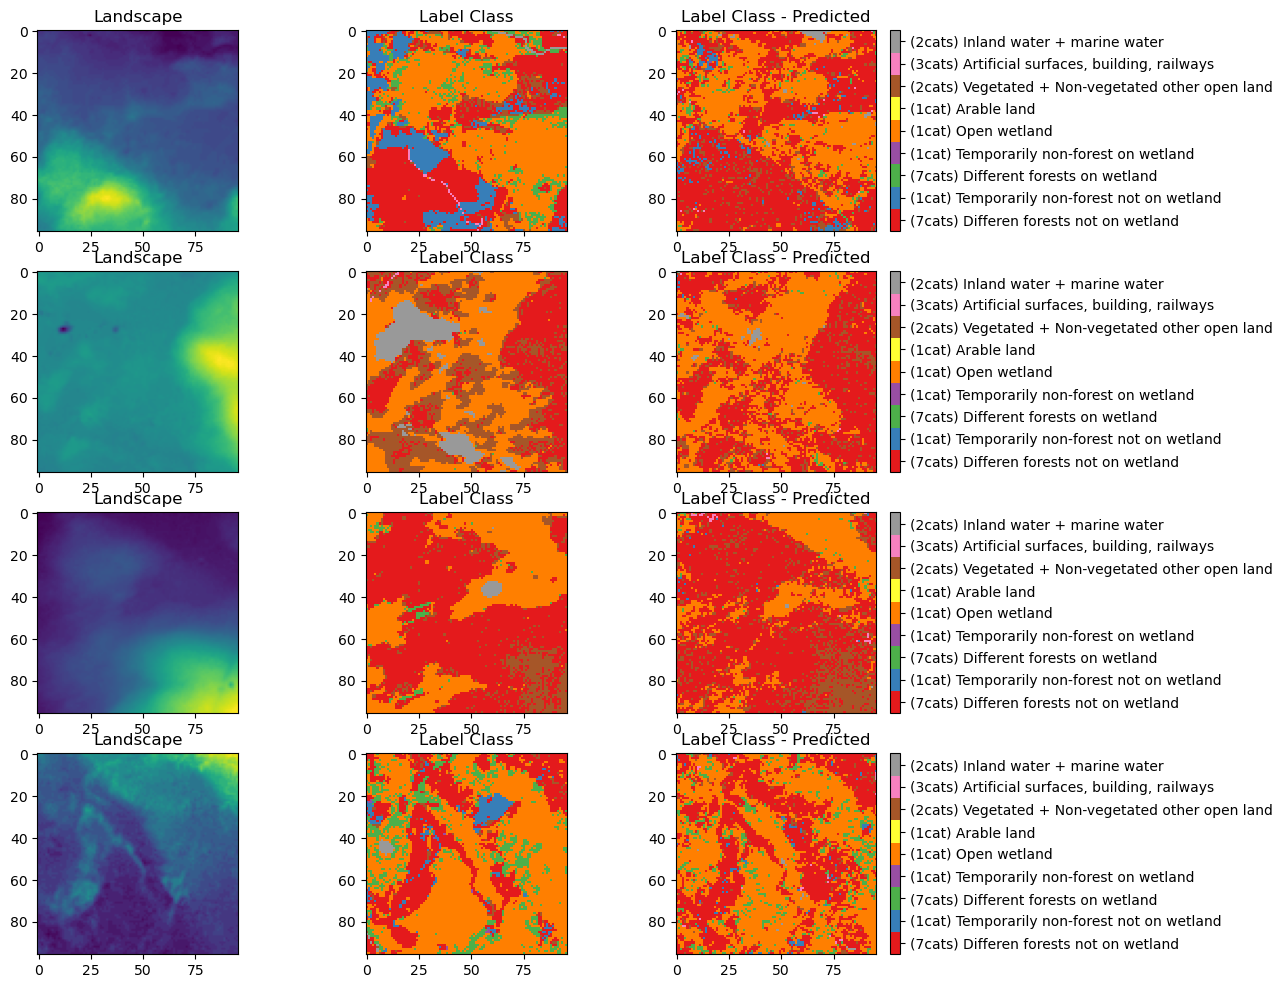

In [43]:
tick_labels = ['(7cats) Differen forests not on wetland',
               '(1cat) Temporarily non-forest not on wetland',
               '(7cats) Different forests on wetland',
               '(1cat) Temporarily non-forest on wetland',
               '(1cat) Open wetland',
               '(1cat) Arable land', 
               '(2cats) Vegetated + Non-vegetated other open land',
               '(3cats) Artificial surfaces, building, railways', 
               '(2cats) Inland water + marine water',
               #'Outside of mapping area'
               ]

num_samples = 4
fig, axes = plt.subplots(num_samples, 3, figsize=(3*4, num_samples*3))

for i in range(num_samples):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='Set1', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 1].set_title("Label Class")
    ax3 = axes[i, 2].imshow(label_class_predicted, cmap='Set1', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 2].set_title("Label Class - Predicted")
    cbar = plt.colorbar(ax3)
    ax3.set_clim(-0.5, 9 - 0.5)
    ticks = np.arange(9)
    cbar.set_ticks(ticks ,labels = tick_labels)
    #cmap='tab10' 'Set1'

# conf matrix


In [48]:
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=9).to(device)
cf_matrix = metric(torch.vstack(Y_pred_list), torch.vstack(Y_list)).data.cpu().numpy()
cf_matrix

array([[8087161,    7288,    2882,      56,    8881,    1112,   26403,
           1017,     790],
       [   3465, 1295195,     232,      62,     483,     140,    1324,
            201,      66],
       [   1641,     346,  700633,      30,    3163,      79,     475,
             49,     148],
       [      7,      20,      22,    3833,       7,       0,       4,
              0,       2],
       [   8528,    1505,    5454,      87, 4810926,     492,    8442,
            148,    2773],
       [      5,       4,       0,       0,       0,    9463,      14,
              6,       0],
       [  22821,    2976,    1257,      45,    7802,    1861, 1946962,
           1216,     888],
       [   2606,     825,     447,       5,     867,     109,    2171,
         185259,     317],
       [   1789,     308,    1046,      26,    8243,     174,    1669,
            393,  719542]])

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_trues_flat, y_preds_flat)

array([[1090870,   34563,   15987,     136,  189496,       2,  112049,
           4016,    5001],
       [ 158494,    8734,    2127,      33,   24636,       0,   12629,
            723,     452],
       [  39456,    1114,    6531,      38,   64339,       0,    3891,
            272,    1199],
       [    459,      34,      35,       0,     373,       0,      42,
              4,      14],
       [ 229587,    5587,   34713,     154,  557949,       0,   31816,
           1803,   18130],
       [    773,      25,      34,       0,     340,       0,      70,
              1,      42],
       [ 232704,    5625,    3515,      28,   58529,       0,   40450,
            827,    1527],
       [  20674,     844,     431,      10,    6822,       0,    2188,
            138,     254],
       [  21007,     447,    2936,      20,   74568,       0,    3510,
            344,   34133]])

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# constant for classes
classes = ('(7cats) Differen forests not on wetland',
               '(1cat) Temporarily non-forest not on wetland',
               '(7cats) Different forests on wetland',
               '(1cat) Temporarily non-forest on wetland',
               '(1cat) Open wetland',
               '(1cat) Arable land', 
               '(2cats) Vegetated + Non-vegetated other open land',
               '(3cats) Artificial surfaces, building, railways', 
               '(2cats) Inland water + marine water',
               #'Outside of mapping area'
            )


Text(120.72222222222219, 0.5, 'True Label')

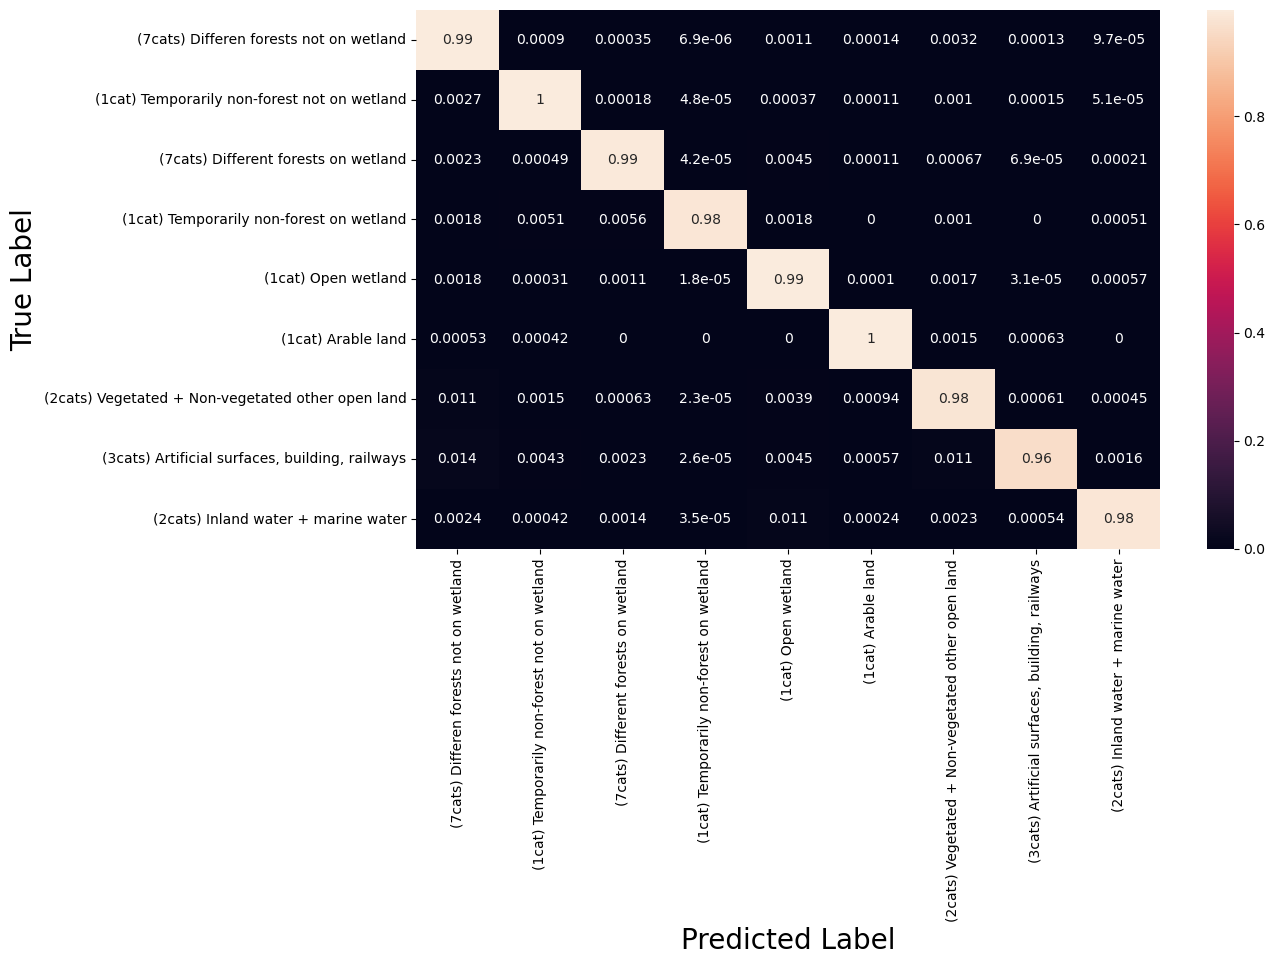

In [22]:
#Train dataset with eval mode
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label',fontsize=20)
plt.ylabel('True Label',fontsize=20)

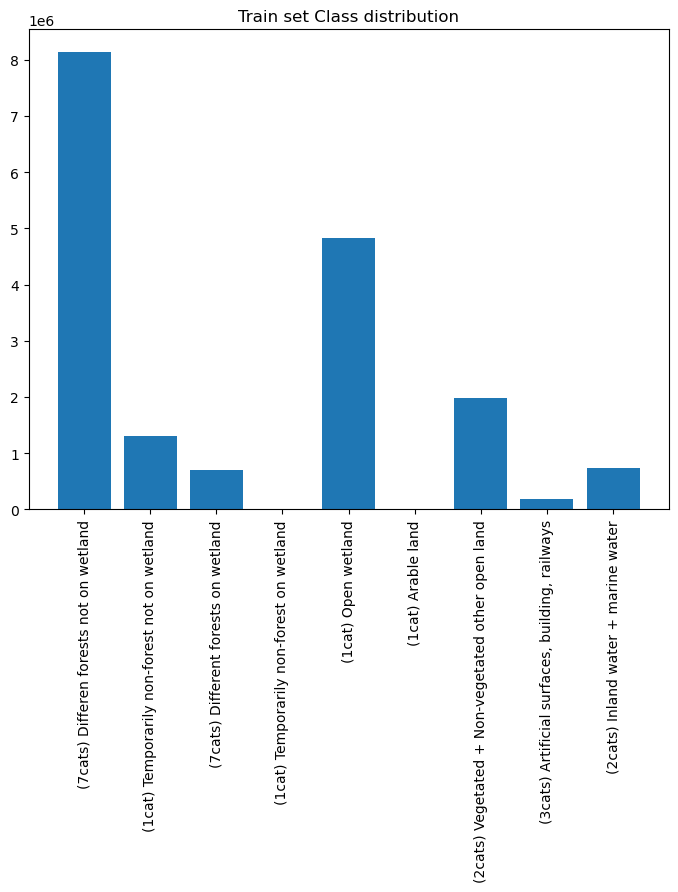

In [49]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(classes,np.bincount(y_trues_flat))
#plt.ticklabel_format(style='plain')
#plt.ticklabel_format(scilimits=(-5, 8))
plt.xticks(rotation='vertical')
plt.title('Train set Class distribution')
plt.show()

Text(120.72222222222219, 0.5, 'True Label')

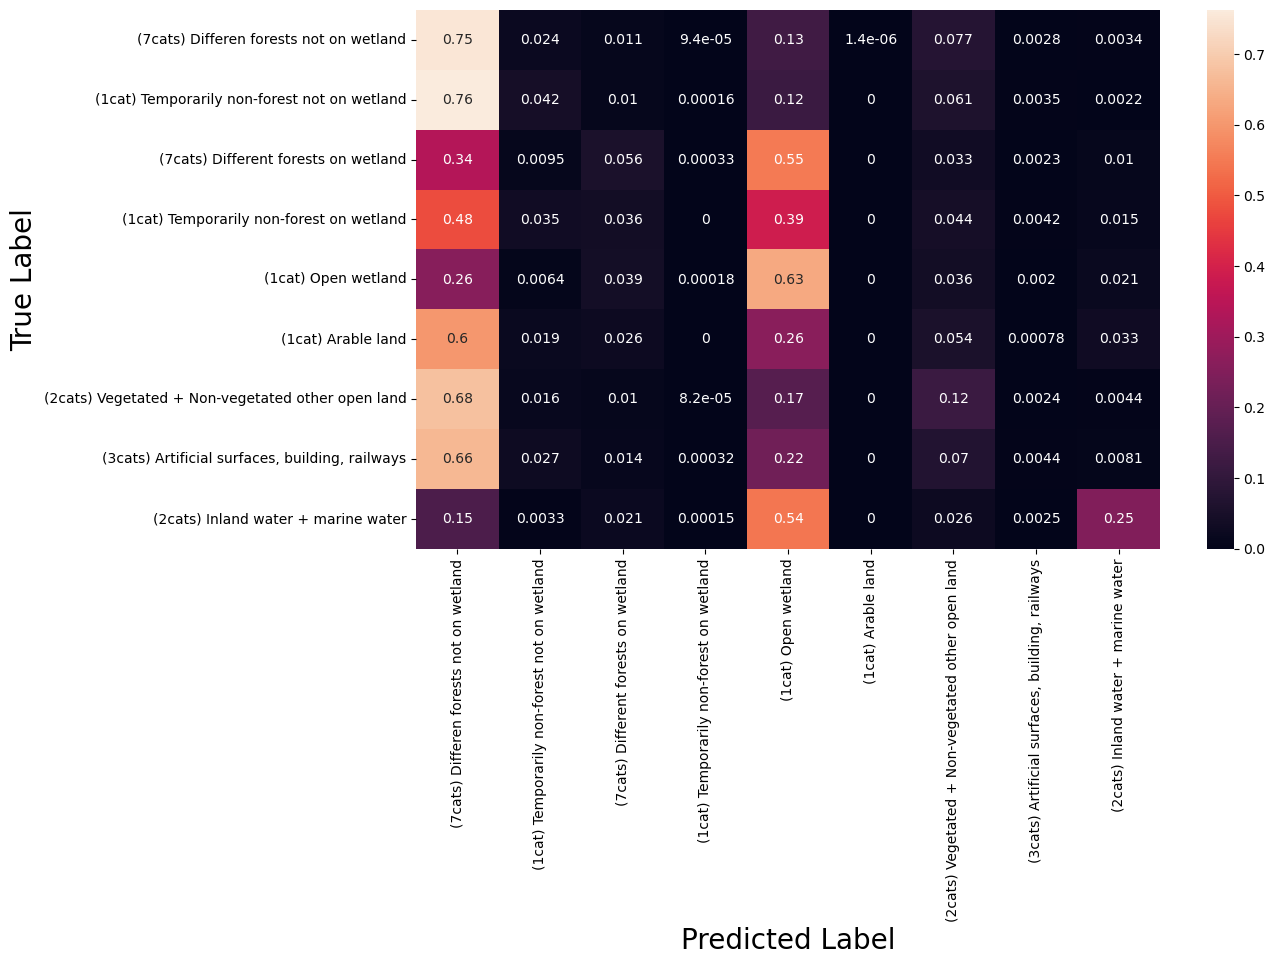

In [29]:
#Test dataset with eval mode
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label',fontsize=20)
plt.ylabel('True Label',fontsize=20)

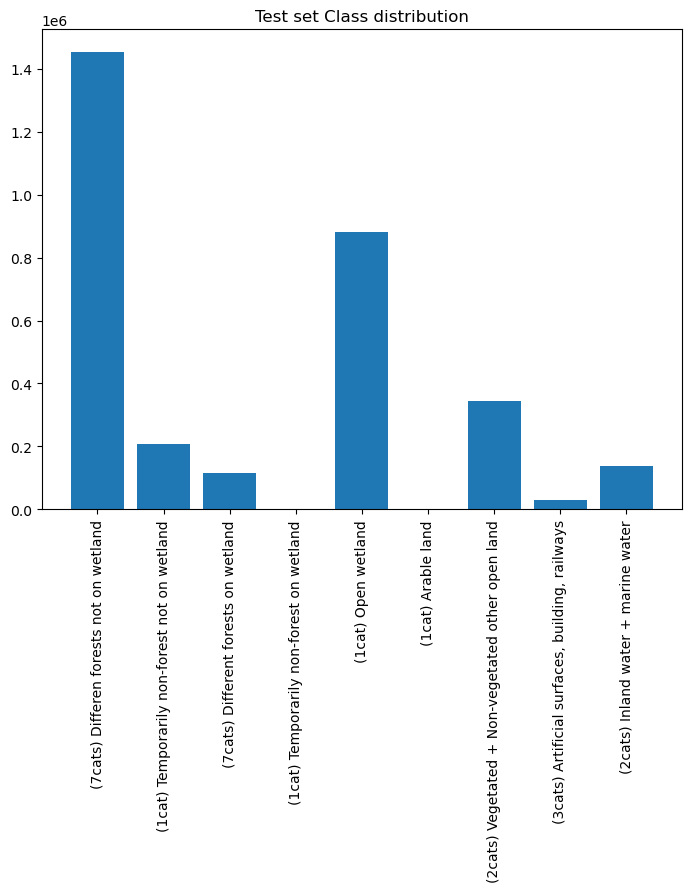

In [44]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(classes,np.bincount(y_trues_flat))
#plt.ticklabel_format(style='plain')
#plt.ticklabel_format(scilimits=(-5, 8))
plt.xticks(rotation='vertical')
plt.title('Test set Class distribution')
plt.show()

# Benchmarking models (random, most frequent class)

In [32]:
print(np.bincount(y_trues_flat))
print("most frequent class: ", np.argmax(np.bincount(y_trues_flat)))

[8711139 1295584  635316    3869 5066977    7668 2218128  204152  832911]
most frequent class:  0


In [77]:
preds_all_zeros = np.zeros(y_trues_flat.shape)

In [79]:
from sklearn.metrics import classification_report
report = classification_report(preds_all_zeros, y_trues_flat,labels=[0, 1, 2, 3,4,5,6,7,8])

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _wa

In [80]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.46      0.63  18975744
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.46  18975744
   macro avg       0.11      0.05      0.07  18975744
weighted avg       1.00      0.46      0.63  18975744



In [81]:
preds_all_random = np.random.randint(9, size=(len(y_trues_flat),))

In [82]:
report = classification_report(preds_all_random, y_trues_flat,labels=[0, 1, 2, 3,4,5,6,7,8])

In [83]:
print(report)

              precision    recall  f1-score   support

           0       0.11      0.46      0.18   2108982
           1       0.11      0.07      0.08   2105351
           2       0.11      0.03      0.05   2109387
           3       0.11      0.00      0.00   2110936
           4       0.11      0.27      0.16   2110460
           5       0.11      0.00      0.00   2107958
           6       0.11      0.12      0.11   2107488
           7       0.11      0.01      0.02   2109012
           8       0.11      0.04      0.06   2106170

    accuracy                           0.11  18975744
   macro avg       0.11      0.11      0.07  18975744
weighted avg       0.11      0.11      0.07  18975744

